# Evaluate "LLM as a Judge" for Transcripts 2.0

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, cohen_kappa_score, precision_score, recall_score, f1_score
import seaborn as sns

# Configure Matplotlib for inline display
%matplotlib inline

In [2]:
# Choose which llm-as-a-judge data to evaluate
common_path = "../../data/evaluations/"

transcripts_version = "1.0"
llm_judge_file = f'transcripts_{transcripts_version}_evaluation_2.csv'

llm_data = pd.read_csv(common_path + llm_judge_file)

# This is from our sweat blood and tears
human_data = pd.read_csv(common_path + '2024-06-06-human-judge.csv')

# rename human_data
human_data = human_data.rename(
    columns={
        "Transcript Number": "transcript_number",

        "Dyspnea": "dyspnea",
        "Paroxysmal Nocturnal Dyspnea (PND)": "pnd",
        "Orthopnea (shortness of breath while lying flat)": "orthopnea",
        "Ankle edema or general lower extremity swelling (swelling in ankles or legs)": "ankle_edema",
        "Nocturnal cough (coughing at night)": "nocturnal_cough",
        "Chest pain": "chest_pain",
        "Fatigue": "fatigue",
        "Worsening mental status that is acute (sudden confusion or mental changes)": "worsening_mental_status",

        "Temperature (body temperature)": "temperature",
        "Heart rate (pulse)": "heart_rate",
        "Respiratory rate (number of breaths per minute)": "respiratory_rate",
        "Oxygen saturation (oxygen level in the blood)": "oxygen_saturation",
        "Blood pressure (systolic and diastolic) (upper and lower blood pressure numbers)": "blood_pressure",
        "Weight (body weight)": "weight",

        "Did the doctor ask the patient what medications they are on?": "doctor_ask_medications",

        "Be sympathetic when the patient reports symptoms or pain.": "sympathetic_patient",
        'Reminder: "Please remember to contact your healthcare provider if you notice any significant changes or worsening of symptoms."': "reminder",
        "End the Conversation: Express care and encourage the patient to reach out if they need further assistance.": "end_conversation",
        "conversation flows naturally: no repetition": "natural_conversation",
        "no premature end to conversation": "no_premature_end",

        "Patient uses plain language": "plain_language",
        "Patient is consistent about their symptoms": "consistent_symptoms",
        "Patient doesn’t invent information that contradicts the prompt (confabulations)": "no_confabulations",
        "Patient allows the doctor to ask questions and doesn’t take over direction of the conversation (offering information before it’s asked for)": "allow_doctor_questions",
    }
)

# Ensure that the transcript numbers are exactly matched, and are in the same order
llm_data = llm_data.sort_values(by='transcript_number', ascending=False).reset_index(drop=True)
human_data = human_data.sort_values(by='transcript_number', ascending=False).reset_index(drop=True)
assert (llm_data['transcript_number'] == human_data['transcript_number']).all()

In [3]:
# display(llm_data.head())

# print all unique values for each column
for col in llm_data.columns:
    if ("_reasoning" not in col) and (col not in ["transcript_number", "observations"]):
        print(col, llm_data[col].unique())

patient_name [1]
dyspnea [1]
pnd [1 0]
orthopnea [1 0]
ankle_edema [1]
nocturnal_cough [1 0]
chest_pain [1]
fatigue [1 0]
worsening_mental_status [1 0]
doctor_ask_medications [1]
temperature [1]
heart_rate [1]
respiratory_rate [1]
oxygen_saturation [1]
blood_pressure [1 0]
weight [1 0]
sympathetic_patient [1]
reminder [1 0]
end_conversation [1 0]
natural_conversation [0 1]
no_premature_end [1 0]
plain_language [1]
consistent_symptoms [1]
no_confabulations [1]
allow_doctor_questions [1]


In [4]:
# display(human_data.head())

# print all unique values for each column
for col in human_data.columns:
    if ("_reasoning" not in col) and (col not in ["transcript_number", "observations"]):
        print(col, human_data[col].unique())

dyspnea [1]
pnd [1 0]
orthopnea [1 0]
ankle_edema [1]
nocturnal_cough [1 0]
chest_pain [1 0]
fatigue [1 0]
worsening_mental_status [1 0]
temperature [1]
heart_rate [1]
respiratory_rate [1]
oxygen_saturation [1]
blood_pressure [1 0]
weight [1 0]
Meds Score [1]
doctor_ask_medications [1]
Qual Score [3.5 3.  2.5 2.  4.  1.5]
Qual Judge Diff [1 0 2 3]
sympathetic_patient [1 0]
reminder [1 0]
end_conversation [1 0]
no_premature_end [1 0]
natural_conversation [0 1]
Patient Score [4.  3.5 2.5 1.5 2.  3. ]
Patient Judge Diff [0 1 3 2]
plain_language [1 0]
consistent_symptoms [1 0]
no_confabulations [1 0]
allow_doctor_questions [1]


In [5]:
question_categories = {
    "symptoms": ["dyspnea", "pnd", "orthopnea", "ankle_edema", "nocturnal_cough", "chest_pain", "fatigue", "worsening_mental_status"],
    "vitals": ["temperature", "heart_rate", "respiratory_rate", "oxygen_saturation", "blood_pressure", "weight"],
    "medications": ["doctor_ask_medications"],
    "hcp_quality": ["sympathetic_patient", "reminder", "end_conversation", "no_premature_end", "natural_conversation"],
    "patient_quality": ["plain_language", "consistent_symptoms", "no_confabulations", "allow_doctor_questions"],
}

feature_columns = [v for values in question_categories.values() for v in values]

/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:730: RuntimeWarning: invalid value encountered in scalar divide
  k = np.sum(w_mat * confusion) / np.sum(w_mat * expected)
/Users/michaelenghoekhor/Library/Caches/pypoetry/virtualenvs/reco-analysis-vNTlTR5M-py3.11/lib/python3.11/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
/Users/michaelenghoekhor/Libra

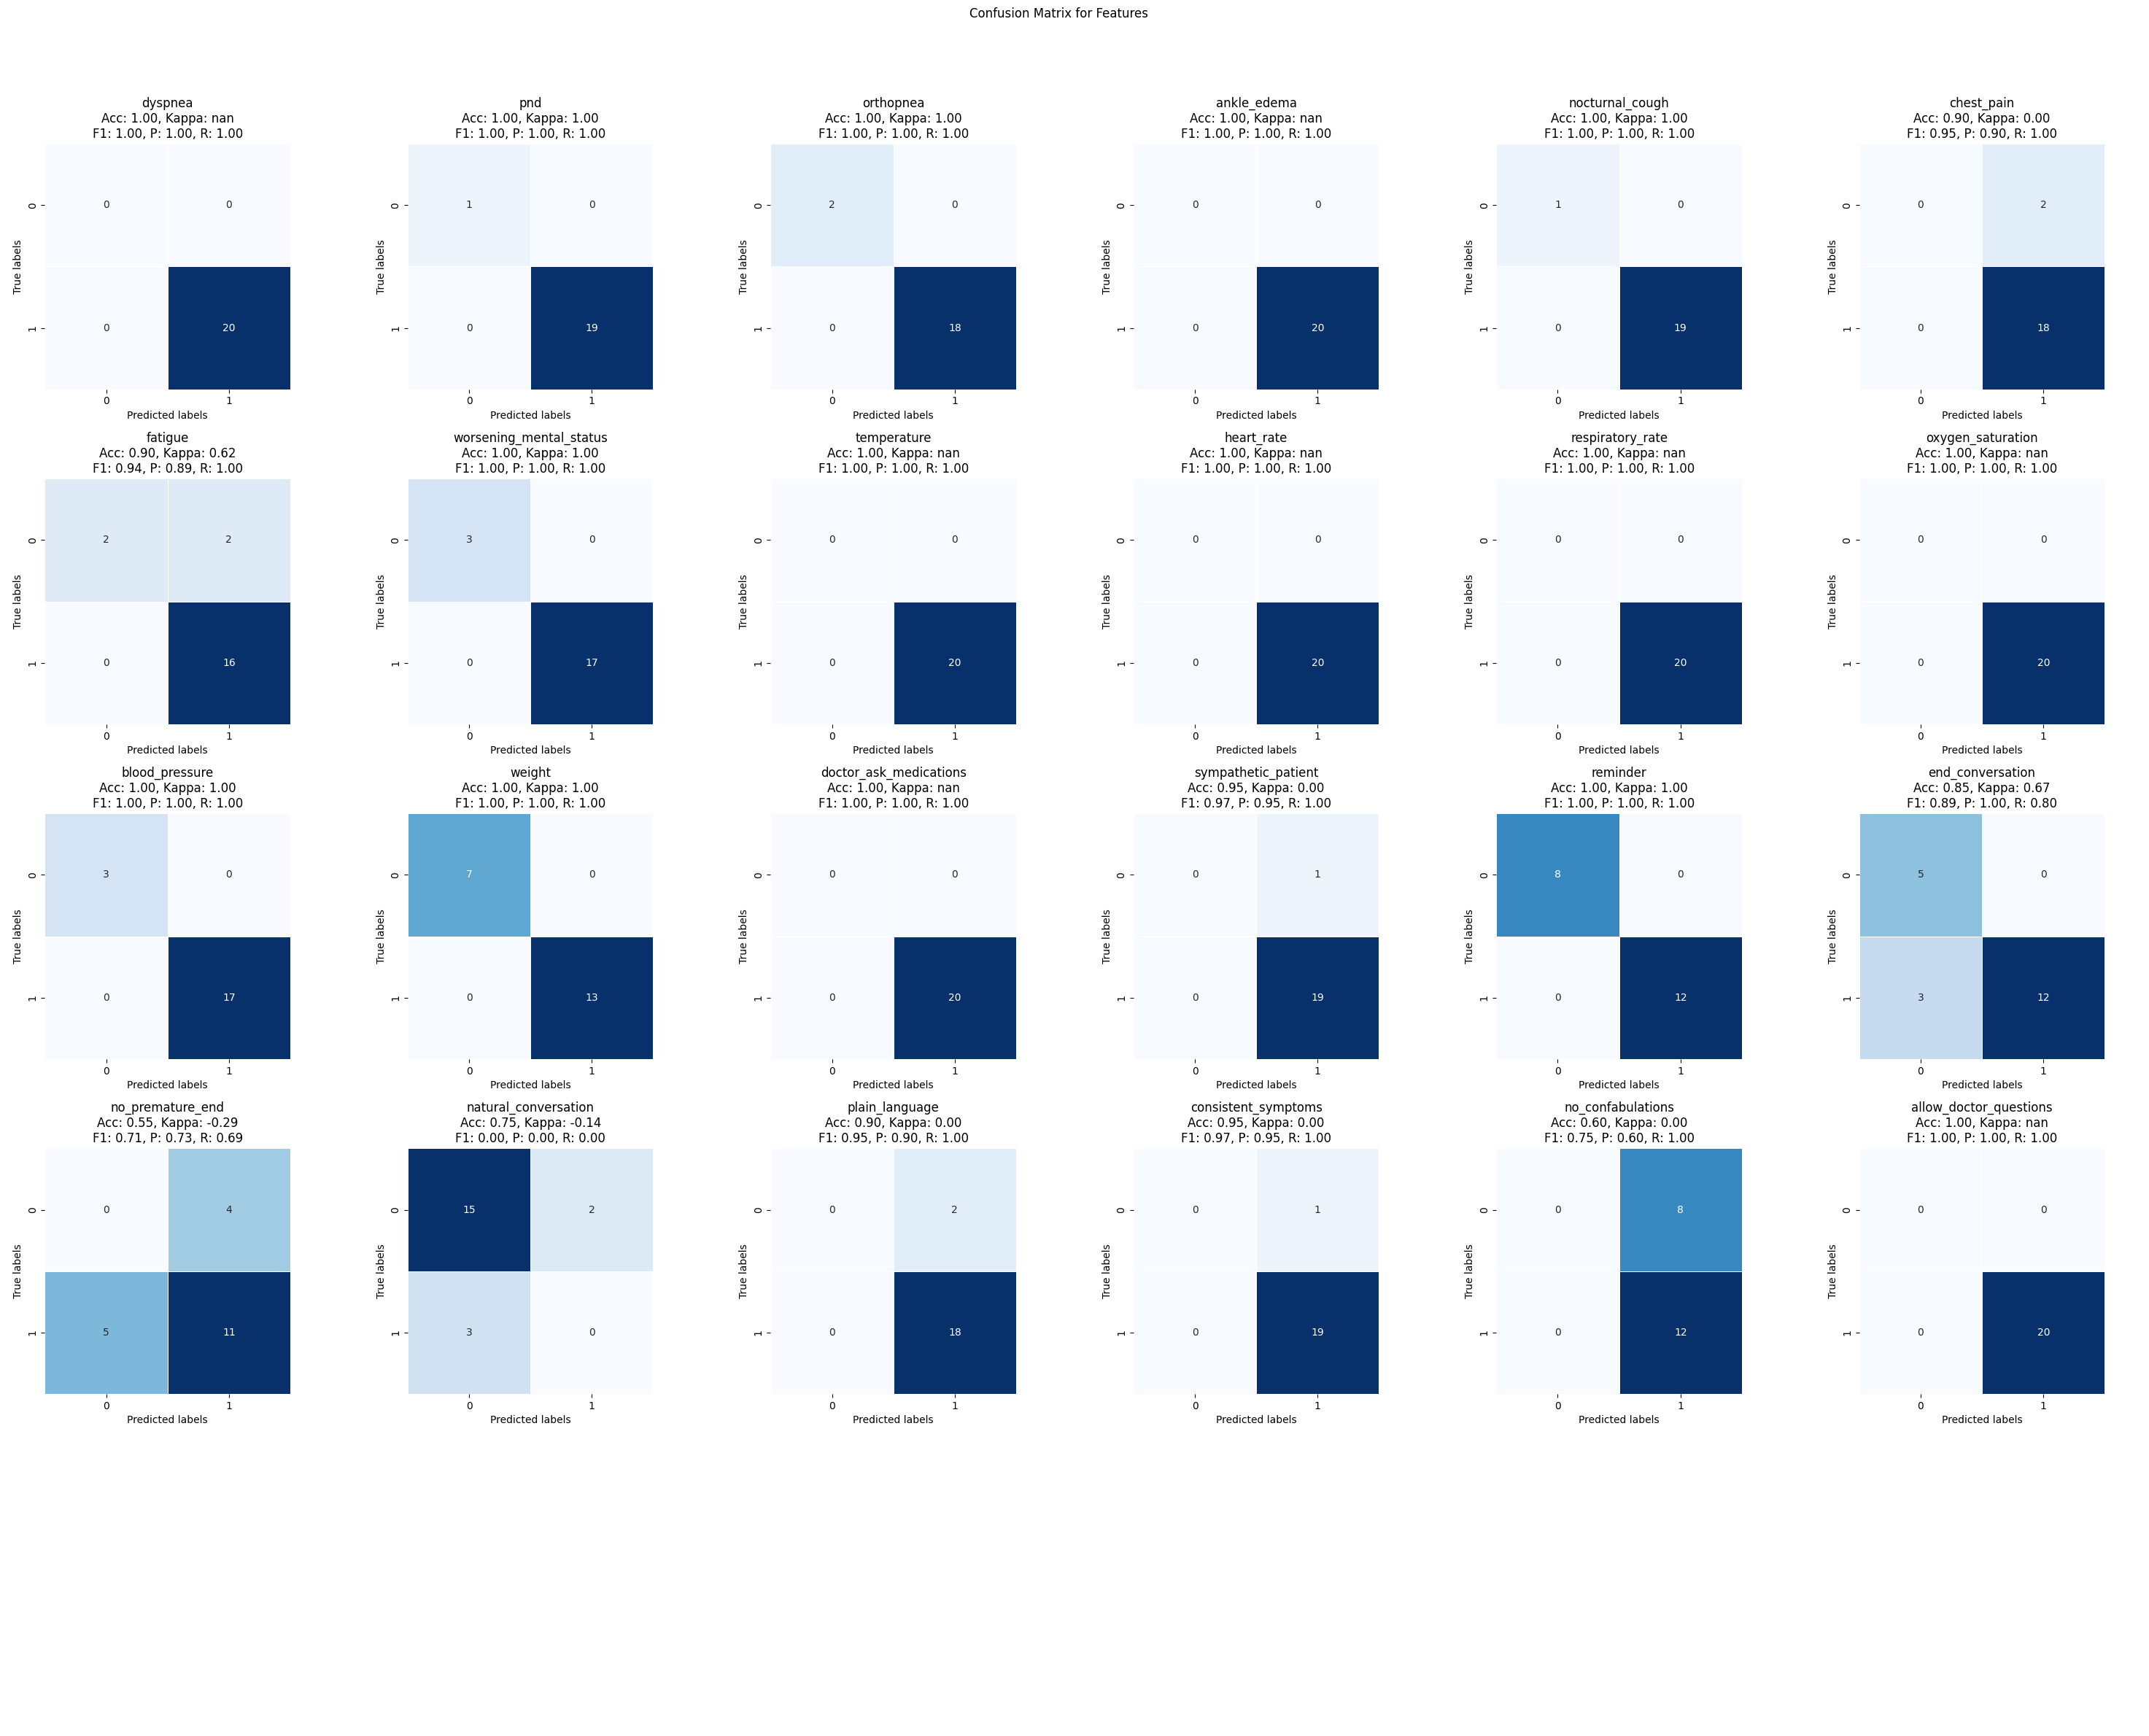

In [6]:
def calculate_metrics(data_true: pd.DataFrame, data_pred: pd.DataFrame, columns: list[str]):
    metrics = {}
    for col in columns:
        tp = np.sum((data_true[col] == 1) & (data_pred[col] == 1))
        tn = np.sum((data_true[col] == 0) & (data_pred[col] == 0))
        fp = np.sum((data_true[col] == 0) & (data_pred[col] == 1))
        fn = np.sum((data_true[col] == 1) & (data_pred[col] == 0))
        accuracy = accuracy_score(data_true[col], data_pred[col])
        kappa = cohen_kappa_score(data_true[col], data_pred[col])
        precision = precision_score(data_true[col], data_pred[col], zero_division=0)
        recall = recall_score(data_true[col], data_pred[col], zero_division=0)
        f1 = f1_score(data_true[col], data_pred[col], zero_division=0)

        metrics[col] = {
            'conf_matrix': [[tn, fp], [fn, tp]],
            'accuracy': accuracy,
            'kappa': kappa,
            'precision': precision,
            'recall': recall,
            'f1': f1
        }
    return metrics


def plot_confusion_matrices(metrics, nrows, ncols, main_title='Confusion Matrices'):
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
    plt.suptitle(main_title)
    axes = axes.flatten()

    for i, (col, data) in enumerate(metrics.items()):
        sns.heatmap(
            data['conf_matrix'],
            annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', ax=axes[i], cbar=False
        )
        axes[i].set_xlabel('Predicted labels')
        axes[i].set_ylabel('True labels')
        axes[i].set_title(f'{col}\nAcc: {data["accuracy"]:.2f}, Kappa: {data["kappa"]:.2f}\nF1: {data["f1"]:.2f}, P: {data["precision"]:.2f}, R: {data["recall"]:.2f}')

    # Hide any unused axes if there are any
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    return fig, axes

# Example usage
metrics = calculate_metrics(human_data, llm_data, feature_columns)
columns_per_row = 6
nrows = len(feature_columns) // columns_per_row + 1
ncols = columns_per_row
fig, axes = plot_confusion_matrices(metrics, nrows, ncols, main_title='Confusion Matrix for Features')
plt.show()


# def plot_confusion_matrix(data_true, data_pred, columns, nrows, ncols, main_title='Confusion matrices'):
#     fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 5 * nrows))
#     plt.title(main_title)
#     axes = axes.flatten()

#     for i, col in enumerate(columns):
#         # cm = confusion_matrix(data_true[col], data_pred[col])
#         tp = np.sum((data_true[col] == 1) & (data_pred[col] == 1))
#         tn = np.sum((data_true[col] == 0) & (data_pred[col] == 0))
#         fp = np.sum((data_true[col] == 0) & (data_pred[col] == 1))
#         fn = np.sum((data_true[col] == 1) & (data_pred[col] == 0))
#         accuracy = accuracy_score(data_true[col], data_pred[col])
#         kappa = cohen_kappa_score(data_true[col], data_pred[col])
#         precision = precision_score(data_true[col], data_pred[col])
#         recall = recall_score(data_true[col], data_pred[col])
#         f1 = f1_score(data_true[col], data_pred[col])

#         sns.heatmap(
#             [[tn, fp], [fn, tp]],
#             annot=True, fmt="d", linewidths=.5, square=True, cmap='Blues', ax=axes[i], cbar=False,
#         )
#         axes[i].set_xlabel('Predicted labels');
#         axes[i].set_ylabel('True labels');
#         axes[i].set_title(f'{col}\nAcc: {accuracy:.2f}, Kappa: {kappa:.2f}\nF1: {f1:.2f}, P: {precision:.2f}, R: {recall:.2f}');

#     # Hide any unused axes if there are any
#     for j in range(i + 1, len(axes)):
#         axes[j].axis('off')

#     plt.tight_layout();

#     return fig, axes

# # Example usage for a specific column
# columns_per_row = 6
# fig, axes = plot_confusion_matrix(
#     human_data_renamed,
#     llm_data_renamed,
#     [c for c in llm_data_renamed.columns if c in feature_columns],
#     len(feature_columns) // columns_per_row + 1,
#     columns_per_row,
#     main_title=f'Confusion Matrix for LLM vs Human Judge: {llm_judge_file}'
# )


,question,conf_matrix,accuracy,kappa,precision,recall,f1,category
0,dyspnea,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,symptoms
1,pnd,"[[1, 0], [0, 19]]",1.0,1.0,1.0,1.0,1.0,symptoms
2,orthopnea,"[[2, 0], [0, 18]]",1.0,1.0,1.0,1.0,1.0,symptoms
3,ankle_edema,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,symptoms
4,nocturnal_cough,"[[1, 0], [0, 19]]",1.0,1.0,1.0,1.0,1.0,symptoms
5,chest_pain,"[[0, 2], [0, 18]]",0.9,0.0,0.9,1.0,0.947368,symptoms
6,fatigue,"[[2, 2], [0, 16]]",0.9,0.615385,0.888889,1.0,0.941176,symptoms
7,worsening_mental_status,"[[3, 0], [0, 17]]",1.0,1.0,1.0,1.0,1.0,symptoms
8,temperature,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,vitals
9,heart_rate,"[[0, 0], [0, 20]]",1.0,NaN,1.0,1.0,1.0,vitals


,category,accuracy
0,hcp_quality,0.82
1,medications,1.0
2,patient_quality,0.8625
3,symptoms,0.975
4,vitals,1.0


/var/folders/qp/hy557z1d5_5ckqwp_fxv8j440000gn/T/ipykernel_60311/3381969427.py:38: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([x.replace("_", " ").capitalize() for x in df_accuracy["question"]])


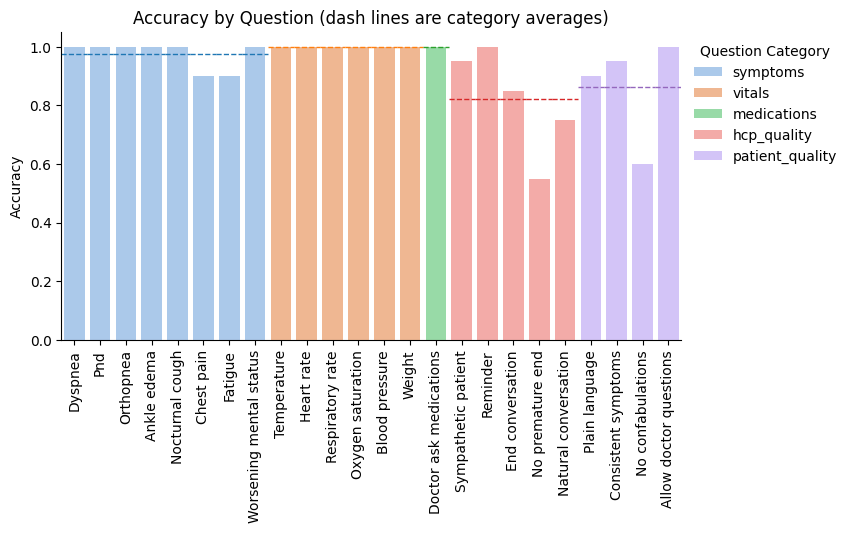

In [8]:
metric_to_plot = "accuracy"  # choose from "accuracy", "kappa", "precision", "recall", "f1"

df_accuracy = pd.DataFrame(metrics).T
df_accuracy["category"] = df_accuracy.index.map(
    lambda x: next((k for k, v in question_categories.items() if x in v), None)
)
df_accuracy.index.name = "question"
df_accuracy.reset_index(inplace=True)
display(df_accuracy)


# calculate average by category
df_accuracy_avg = df_accuracy.groupby("category")[metric_to_plot].mean().reset_index()
display(df_accuracy_avg)

# now plot metric by question
fig, ax = plt.subplots(figsize=(8, 4))

sns.barplot(data=df_accuracy, x="question", y=metric_to_plot, hue="category", ax=ax, palette="pastel")

# either add and format legend
plt.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Question Category")
ax.get_legend().get_frame().set_linewidth(0.0)

# or remove legend
# ax.get_legend().remove()

# also plot the averages using dashed lines
sns.set_palette("tab10")
for i, question in enumerate(df_accuracy["question"]):
    category = df_accuracy.loc[df_accuracy["question"] == question, "category"].values[0]
    avg = df_accuracy_avg.loc[df_accuracy_avg["category"] == category, metric_to_plot].values[0]
    category_idx = df_accuracy["category"].unique().tolist().index(category)
    color = sns.color_palette()[category_idx]
    ax.plot([i - 0.5, i + 0.5], [avg, avg], color=color, linestyle="--", linewidth=1)

# change the text in x-axis ticks to remove "_" and capitalize and add newlines (only the last "_")
ax.set_xticklabels([x.replace("_", " ").capitalize() for x in df_accuracy["question"]])

ax.set_xlim(-0.5, len(df_accuracy) - 0.5)
ax.set_ylim(0, 1.05)
ax.set_title(f"{metric_to_plot.capitalize()} by Question (dash lines are category averages)")
ax.set_ylabel(metric_to_plot.capitalize())
ax.set_xlabel(None)
plt.xticks(rotation=90, ha='center')

# remove top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()